In [1]:
# !source .venv/bin/activate

In [2]:
import os
import torch
from PIL import Image
import numpy as np
import cv2

In [3]:
from grounding_dino import groundingdino

In [4]:

import sam2
from sam2.utils.track_utils import sample_points_from_masks
from sam2.utils.video_utils import create_video_from_images
from sam2.build_sam import build_sam2_video_predictor, build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor



In [5]:
ROOT_DIR = '/workspace/SKU_segment/sku_segment'
BASE_DIR = '/workspace/SKU_segment'

In [6]:
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.1'

device = ("cuda" if torch.cuda.is_available() else "cpu")


sam2_config_dir = os.path.join(ROOT_DIR, 'configs')
checkpoint_dir = os.path.join(BASE_DIR, 'checkpoints')
sam2_checkpoint_name='sam2.1_hiera_large.pt'
sam2_config_name='sam2.1_hiera_l.yaml'

sam2_checkpoint = os.path.join(checkpoint_dir,sam2_checkpoint_name)
sam2_model_cfg = os.path.join(sam2_config_dir,sam2_config_name)


sam2_image_model = build_sam2(sam2_config_name, sam2_checkpoint, device=device)
print(f"SAM2 image model loaded from {sam2_checkpoint}")

image_predictor = SAM2ImagePredictor(sam2_image_model, device=device)
print(f"image_predictor loaded from SAM2 image model")

SAM2 image model loaded from /workspace/SKU_segment/checkpoints/sam2.1_hiera_large.pt
image_predictor loaded from SAM2 image model


In [7]:
image_path = 'brick_1.jpg'

image_pil = Image.open(image_path).convert("RGB")
image_np = np.array(image_pil)
vis_image = image_np.copy() 
image_predictor.set_image(image_pil)
image_tensor = torch.tensor(image_np).permute(2, 0, 1).float() / 255.0


prompt = "brick"

h,w = image_pil.size

x1 = 0
y1 = 0
x2 = w
y2 = h


# Predict masks
sam_masks, scores, _ = image_predictor.predict(
    box=np.array([x1, y1, x2, y2]),
    multimask_output=False,
    return_logits=False,
)

best_mask = sam_masks[0]
best_mask = 1 - best_mask
Image.fromarray((best_mask * 255).astype(np.uint8)).save(os.path.join('', image_path.replace(".jpg", "_mask.png")))

# Overlay mask on vis_image
mask_color = np.zeros_like(vis_image)
mask_color[best_mask > 0] = (0, 255, 0)  # Green
vis_image = cv2.addWeighted(vis_image, 1.0, mask_color, 0.3, 0)


vis_path = os.path.join('', image_path.replace(".jpg", "_overlay.jpg"))
cv2.imwrite(vis_path, cv2.cvtColor(vis_image, cv2.COLOR_RGB2BGR))

/workspace/SKU_segment/sku_segment/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:607.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/workspace/SKU_segment/sku_segment/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/workspace/SKU_segment/sku_segment/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:609.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/workspace/SKU_segment/sku_segment/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: {Hal

True

In [8]:

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
clean_mask  = cv2.morphologyEx(best_mask, cv2.MORPH_OPEN, kernel, iterations=2)
clean_mask  = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

mask_uint8 = (clean_mask * 255).astype(np.uint8)

Image.fromarray((clean_mask * 255).astype(np.uint8)).save(os.path.join('', image_path.replace(".jpg", "_mask_cleaned.png")))


In [9]:
min_area_px = 100

def area_norm(S):
    return S/(image_pil.size[0]*image_pil.size[1])


def aspect_penalty(x):
    if 1.5 < x < 2.2:
        return 1
    else:
        return 0


def vertex_penalty(n):
    if 4 <= n <= 6:
        return 1
    else:
        return 0

        
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"{len(contours)} contours found")


candidates = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < min_area_px:          # weed out speckles
        continue

    hull = cv2.convexHull(cnt)
    solidity = area / cv2.contourArea(hull)

    # polygonal approximation
    eps = 0.01 * cv2.arcLength(cnt, True)
    poly = cv2.approxPolyDP(hull, eps, True)
    n = len(poly)

    # min‑area rectangle
    rect = cv2.minAreaRect(cnt)
    w,h = rect[1]
    if min(w,h) == 0:               # degenerate
        continue
    aspect = max(w,h) / min(w,h)

    score = (
        0.2 * area_norm(area) +     # size dominates
        0.0 * solidity +            # prefer compact
        0.0 * aspect_penalty(aspect) +
        0.0 * vertex_penalty(n)     # gentle push toward 4–6 verts
    )
    candidates.append((score, cnt, poly))


best = max(candidates, key=lambda x: x[0])
best_cnt, best_poly = best[1], best[2]


# contour = max(contours, key=cv2.contourArea)
# epsilon = 0.01 * cv2.arcLength(contour, True)
# hull = cv2.convexHull(contour)
# approx = cv2.approxPolyDP(hull, epsilon, True)

# if 4 <= len(approx) <= 6:
#     best_poly = approx

8 contours found


In [10]:
import matplotlib.pyplot as plt

canvas = cv2.cvtColor(clean_mask, cv2.COLOR_GRAY2BGR)

# Draw polygon outline
cv2.polylines(canvas, [best_poly], isClosed=True, color=(0, 255, 0), thickness=2)

# Draw vertices
for (x, y) in best_poly.reshape(-1, 2):
    cv2.circle(canvas, (x, y), 4, (0, 0, 255), -1)

# Show the result
# plt.figure(figsize=(6, 6))
# plt.title(f"Contour {i} — Polygon with {len(approx)} vertices")
# plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()



# for i, cnt in enumerate(contours):
#     print(f"Contour {i}")

#     # Convex hull (optional)
#     hull = cv2.convexHull(cnt)

#     # Polygonal approximation
#     epsilon = 0.01 * cv2.arcLength(hull, True)
#     approx = cv2.approxPolyDP(hull, epsilon, True)

#     # Make a fresh canvas per contour
#     canvas = cv2.cvtColor(clean_mask, cv2.COLOR_GRAY2BGR)

#     # Draw polygon outline
#     cv2.polylines(canvas, [approx], isClosed=True, color=(0, 255, 0), thickness=2)

#     # Draw vertices
#     for (x, y) in approx.reshape(-1, 2):
#         cv2.circle(canvas, (x, y), 4, (0, 0, 255), -1)

#     # Show the result
#     plt.figure(figsize=(6, 6))
#     plt.title(f"Contour {i} — Polygon with {len(approx)} vertices")
#     plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
#     plt.axis("off")
#     plt.show()




In [11]:
import cv2
import numpy as np

def split_brick_face(hexagon: np.ndarray):
    """
    hexagon : (6,2) array of xy vertices, ordered around the perimeter.
    Returns:
        quad_A, quad_B  # each is (4,2) array of xy vertices
    """

    # ------------------------------------------------------------------
    # 1. Compute edge vectors and their directions (unit normals)
    # ------------------------------------------------------------------
    edges   = np.roll(hexagon, -1, axis=0) - hexagon           # v_i = x_{i+1} - x_i
    norms   = edges / np.linalg.norm(edges, axis=1, keepdims=True)

    # ------------------------------------------------------------------
    # 2. Group edges into three parallel pairs
    #    We do this by clustering their angles (k‑means‑1D with k=3).
    # ------------------------------------------------------------------
    angles        = np.arctan2(norms[:, 1], norms[:, 0])        # angle of each edge
    angles        = (angles + 2*np.pi) % np.pi                  # fold 180° symmetry
    sorted_idx    = np.argsort(angles)
    groups        = [sorted_idx[[0, 3]], sorted_idx[[1, 4]], sorted_idx[[2, 5]]]

    # Groups come out unsorted — ensure they match your notation
    # We’ll re‑label so that (x1x2,x4x5) is group0 etc.
    # Because vertices are ordered, the opposite edge to index i is (i+3)%6
    g0 = np.array([0, 3])
    g1 = np.array([1, 4])
    g2 = np.array([5, 2])        # (x6x1, x3x4)

    # ------------------------------------------------------------------
    # 3. Compute the two “missing” vertices y1 and y2
    # ------------------------------------------------------------------
    x  = hexagon
    y1 = x[5] + (x[1] - x[0])    # x6 + vec(x1→x2)
    y2 = x[2] + (x[4] - x[3])    # x3 + vec(x4→x5)

    # ------------------------------------------------------------------
    # 4. Assemble the two quads
    # ------------------------------------------------------------------
    quad_front = np.vstack([x[1], x[2], x[3], y1])   # x2‑x3‑x4‑y1
    quad_top   = np.vstack([x[0], y2, x[4], x[5]])   # x1‑y2‑x5‑x6

    return quad_front.astype(np.float32), quad_top.astype(np.float32)


In [12]:
# `approx` is the (6,1,2) array from cv2.approxPolyDP → reshape to (6,2)
hexagon = best_poly.reshape(-1, 2)
quadA, quadB = split_brick_face(hexagon)

print("Quad A vertices:\n", quadA)
print("Quad B vertices:\n", quadB)


Quad A vertices:
 [[525. 212.]
 [111. 297.]
 [ 31. 212.]
 [401. 153.]]
Quad B vertices:
 [[535.  93.]
 [114. 179.]
 [ 34.  94.]
 [411.  34.]]


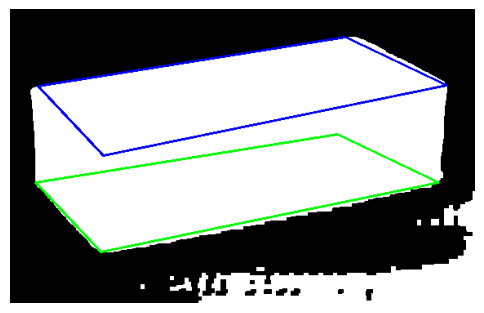

In [17]:
def draw_quads(img, quadA, quadB):
    # Check shapes
    if quadA.shape != (4, 2) or quadB.shape != (4, 2):
        raise ValueError("Quads must have shape (4, 2)")

    # Sanitize input for OpenCV
    quadA = np.round(quadA).astype(int).reshape(1, 4, 2)
    quadB = np.round(quadB).astype(int).reshape(1, 4, 2)

    # Draw contours
    cv2.polylines(img, [quadA], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.polylines(img, [quadB], isClosed=True, color=(255, 0, 0), thickness=2)


canvas = cv2.cvtColor(clean_mask, cv2.COLOR_GRAY2BGR)
draw_quads(canvas, quadA, quadB)

plt.figure(figsize=(6, 6))
plt.title("")
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [19]:
# # image_pts: np.float32 shape (4,2)
# # object_pts: np.float32 shape (4,3)
# ok, rvec, tvec = cv2.solvePnP(object_pts, image_pts,
#                               K, distCoeffs,
#                               flags=cv2.SOLVEPNP_IPPE_SQUARE)
# R, _ = cv2.Rodrigues(rvec)
# n_cam = R[:, 2]                          # outward normal in camera frame
